# Unzip dataset

In [1]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/ba/
  inflating: dataset/ba/ba_01.jpg    
  inflating: dataset/ba/ba_02.jpg    
  inflating: dataset/ba/ba_03.jpg    
  inflating: dataset/ba/ba_04.jpg    
  inflating: dataset/ba/ba_05.jpg    
  inflating: dataset/ba/ba_06.jpg    
  inflating: dataset/ba/ba_07.jpg    
  inflating: dataset/ba/ba_08.jpg    
  inflating: dataset/ba/ba_09.jpg    
  inflating: dataset/ba/ba_10.jpg    
  inflating: dataset/ba/ba_100.jpg   
  inflating: dataset/ba/ba_11.jpg    
  inflating: dataset/ba/ba_12.jpg    
  inflating: dataset/ba/ba_13.jpg    
  inflating: dataset/ba/ba_14.jpg    
  inflating: dataset/ba/ba_15.jpg    
  inflating: dataset/ba/ba_16.jpg    
  inflating: dataset/ba/ba_17.jpg    
  inflating: dataset/ba/ba_18.jpg    
  inflating: dataset/ba/ba_19.jpg    
  inflating: dataset/ba/ba_20.jpg    
  inflating: dataset/ba/ba_21.jpg    
  inflating: dataset/ba/ba_22.jpg    
  inflating: dataset/ba/ba_23.jpg    
  inflating: datase

# Import libraries

In [38]:
import tensorflow as tf
import PIL
from matplotlib import pyplot as plt
import os
import numpy as np
from tensorflow.keras.applications import MobileNetV2

# Set Constants

In [7]:
IMG_HEIGHT = 96
IMG_WIDTH = 96
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH, 3)  # Adjust image size as per your dataset
DATA_DIR = 'dataset'
NUM_CLASSES = 18  # Number of classes
VALIDATION_SPLIT = 0.2  # 20% validation split
SEED = 42
BATCH_SIZE = 32   # Global batch size

# Visualization Tools

In [36]:
def visualize_data(dataset, label_class, num_images=5):
  """Visualizes images, labels, and bounding boxes from the dataset.

  Args:
    dataset: The  dataset.
    num_images: The number of images to visualize.
  """
  plt.figure(figsize=(15, 5))

  # Iterate through the dataset and visualize images
  for i, (image_batch, label_batch) in enumerate(dataset.take(num_images)):
    for j in range(min(image_batch.shape[0], num_images)):  # Visualize up to 5 images per batch
      image = image_batch[j].numpy()
      label = np.argmax(label_batch[j].numpy())  # Get the class label

      # Display the image
      plt.subplot(1, 5, j + 1)
      plt.imshow(image)
      plt.title(f"Label: {label} ({label_class[label]})")
      plt.axis("off")
    plt.show()  # Show the plot after each batch

# Load Dataset

In [25]:
def one_hot(image, label):
  """One-hot encodes the label."""
  label = tf.keras.utils.to_categorical(label, NUM_CLASSES)
  # Normalize image
  image = tf.cast(image, tf.float32) / 255.0
  return tf.data.Dataset.from_tensor_slices(([image], [label]))


def get_dataset(seed):
    """Loads and processes the training dataset without validation split."""
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        DATA_DIR,
        seed=SEED,
        batch_size=None,  # Single image per batch for easy processing
        image_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    # Get class names
    class_names = dataset.class_names
    dataset = dataset.flat_map(one_hot)

    return dataset, class_names

def split_dataset(dataset, train_split=0.8, shuffle_buffer=1000, seed=None):
    """Splits a dataset into training, validation and testing sets."""
    # Shuffle the dataset
    dataset = dataset.shuffle(buffer_size=shuffle_buffer, seed=seed, reshuffle_each_iteration=False)

    # Calculate split sizes
    dataset_size = len(list(dataset))
    train_size = int(dataset_size * train_split)
    val_size = int(dataset_size * (1 - train_split) / 2)
    test_size = val_size

    # Split the dataset
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

In [27]:
dataset, class_names = get_dataset(seed=SEED)
train_datset, val_dataset, test_dataset = split_dataset(dataset, train_split=1 - VALIDATION_SPLIT, seed=SEED)

Found 1800 files belonging to 18 classes.


In [29]:
label_to_class = {i: class_name for i, class_name in enumerate(class_names)}
print(label_to_class)  # Example: {0: 'cat', 1: 'dog'}

{0: 'ba', 1: 'ca', 2: 'da', 3: 'ga', 4: 'ha', 5: 'ja', 6: 'ka', 7: 'la', 8: 'ma', 9: 'na', 10: 'nga', 11: 'nya', 12: 'pa', 13: 'ra', 14: 'sa', 15: 'ta', 16: 'wa', 17: 'ya'}


In [30]:
# Batch data
train_dataset = train_datset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Check number of data for every set

In [31]:
total_training_images = 0
for _ in train_dataset:
    total_training_images += 1

print(f"Total number of images in the training dataset: {total_training_images * 32}")

total_validation_images = 0
for _ in val_dataset:
    total_validation_images += 1

print(f"Total number of images in the validation dataset: {total_validation_images * 32}")

total_test_images = 0
for _ in test_dataset:
    total_test_images += 1

print(f"Total number of images in the test dataset: {total_test_images * 32}")

Total number of images in the training dataset: 1440
Total number of images in the validation dataset: 192
Total number of images in the test dataset: 192


# Check size

In [32]:
for image_batch, label_batch in train_dataset.take(1):
    print("Training Image batch shape:", image_batch.shape)
for image_batch, label_batch in val_dataset.take(1):
    print("Validation Image batch shape:", image_batch.shape)
for image_batch, label_batch in test_dataset.take(1):
    print("Testing Image batch shape:", image_batch.shape)

Training Image batch shape: (32, 96, 96, 3)
Validation Image batch shape: (32, 96, 96, 3)
Testing Image batch shape: (32, 96, 96, 3)


# Visualize Data

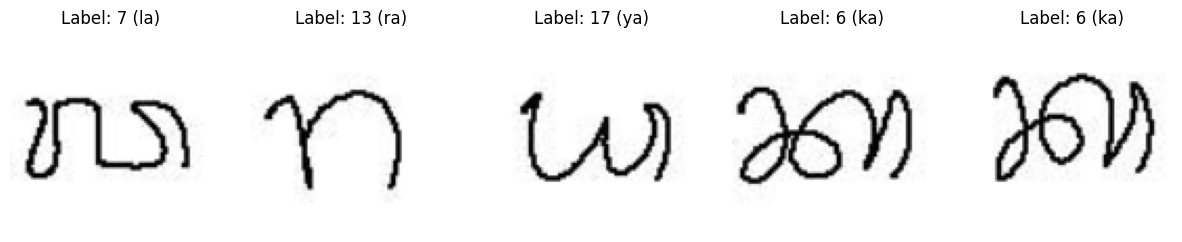

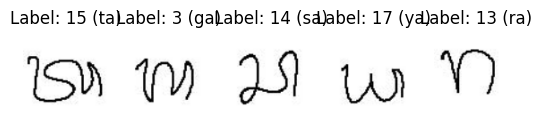

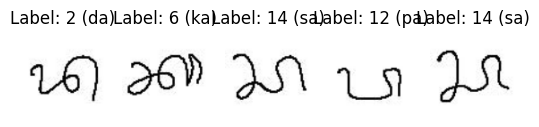

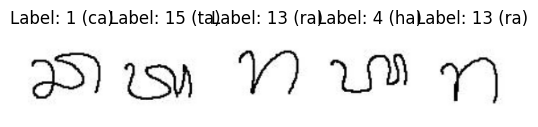

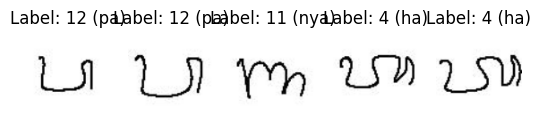

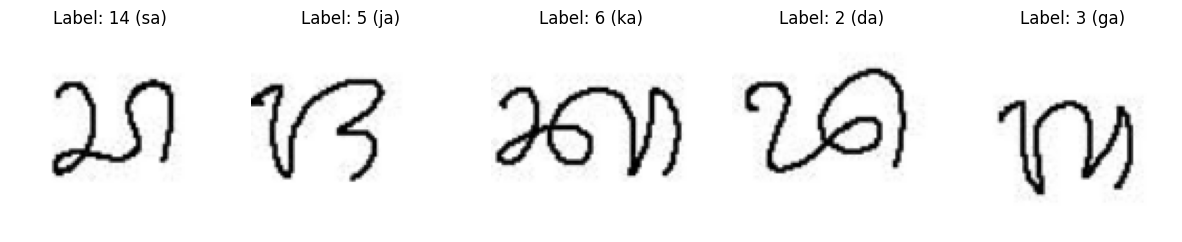

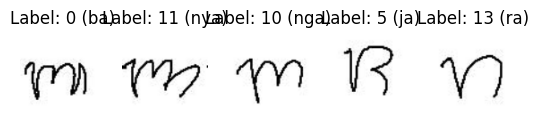

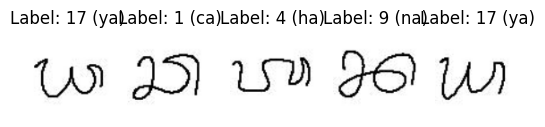

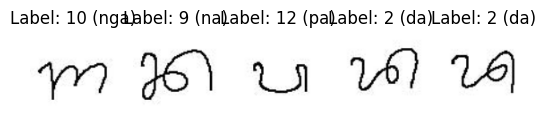

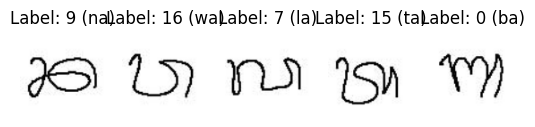

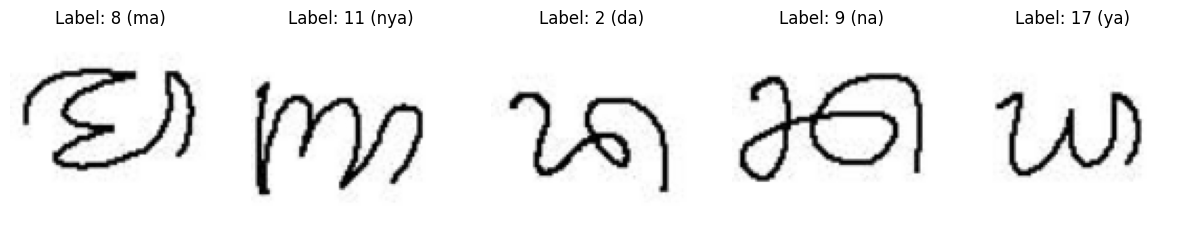

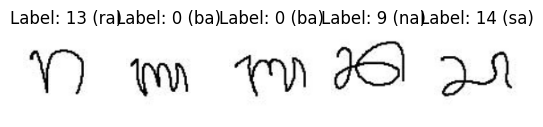

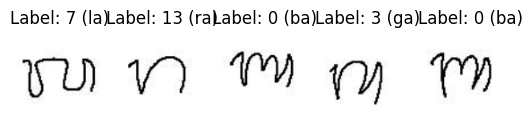

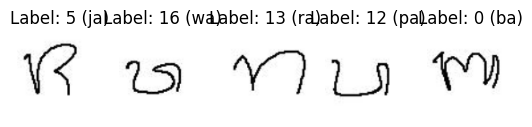

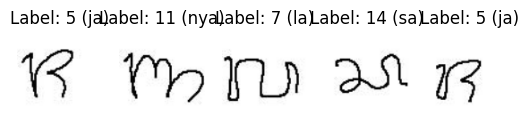

In [37]:
visualize_data(train_dataset, class_names, num_images=5)
visualize_data(val_dataset, class_names, num_images=5)
visualize_data(test_dataset, class_names, num_images=5)

# Define Model

In [76]:
def create_model(unfreeze_layers, unfreeze=True):
  # Load the MobileNetV2 model
  mobilenet_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=IMG_SIZE)
  if unfreeze:
    # Freeze all layers initially
    mobilenet_model.trainable = False

    # Unfreeze the last 10 layers
    for layer in mobilenet_model.layers[-unfreeze_layers:]:
        layer.trainable = True
  else:
    mobilenet_model.trainable = False

  model = tf.keras.Sequential([
    mobilenet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(256, activation="relu"),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
  ])

  return model


In [46]:
# Define custom callbacks
class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    # Define the correct function signature for on_epoch_end method
    def on_epoch_end(self, epoch, logs=None):
        # Check if the accuracy is greater or equal to 0.95 and validation accuracy is greater or equal to 0.8
        if logs['accuracy'] >= 0.95 and logs['val_accuracy'] >= 0.8:
            self.model.stop_training = True

            print("\nReached 95% train accuracy and 80% validation accuracy, so cancelling training!")

In [77]:
model = create_model(0, unfreeze=False)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96 (Functional)     │ (None, 3, 3, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 18)                  │           9,234 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,923,090 (11.15 MB)

 Trainable params: 665,106 (2.54 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [78]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    steps_per_epoch=total_training_images // BATCH_SIZE
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.0312 - loss: 4.0968 - val_accuracy: 0.0782 - val_loss: 3.1503
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0312 - loss: 3.6640

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step - accuracy: 0.0312 - loss: 3.6640 - val_accuracy: 0.1788 - val_loss: 2.8525
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step - accuracy: 0.0625 - loss: 3.1205 - val_accuracy: 0.2682 - val_loss: 2.4266
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step - accuracy: 0.3125 - loss: 2.2439 - val_accuracy: 0.3408 - val_loss: 2.2679
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step - accuracy: 0.3438 - loss: 2.3470 - val_accuracy: 0.4078 - val_loss: 2.0933
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step - accuracy: 0.2812 - loss: 2.2552 - val_accuracy: 0.3911 - val_loss: 1.9865
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - accuracy: 0.2500 - loss: 2.6610 - val_accuracy: 0.4358 - val_loss: 1.8333
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.4062 - loss: 1.8930 - val_accuracy: 0.6034 - val_loss: 1.5625
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step - accuracy: 0.3125 - loss: 2.1661 - val_accuracy: 0.6369 - val_loss: 1.3

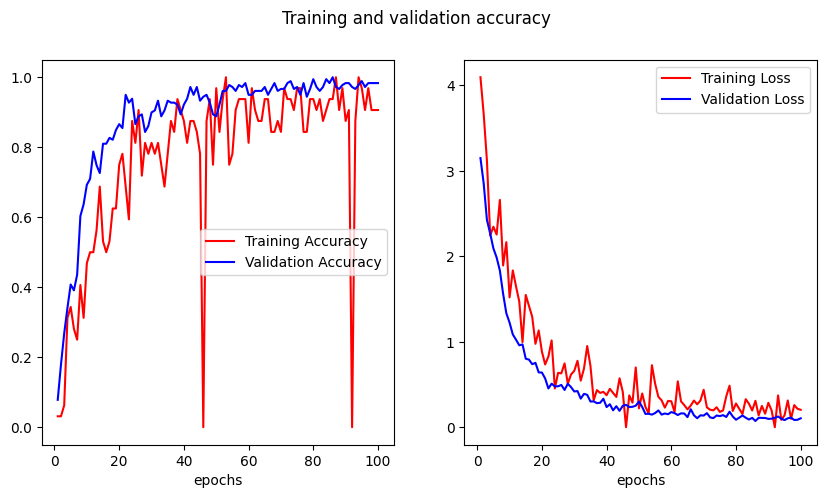

In [79]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(1, len(acc) + 1) # Generate a sequence of numbers from 1 to the number of epochs trained

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [80]:
loss, accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9690 - loss: 0.1119
Test Loss: 0.11398050934076309
Test Accuracy: 0.9664804339408875


# Save Model

In [81]:
model.save('classification_model_v2.keras')

In [82]:
model.save('classification_model_v2.h5')